# Introduction

In this file, the dataset from https://www.kaggle.com/datasets/kinguistics/heartbeat-sounds?resource=download will be analyzed. Moreover, a detailed Exploratory Data Analysis (EDA) will be carried out. This will be followed by features extraction and then using Deep Learning Architecture i.e. CNN to classify between Normal and Abnormal Heartbeats.

# Data Description

**Content**:
The dataset is split into two sources, A and B:

***set_a.csv*** - Labels and metadata for heart beats collected from the general public via an iPhone app

***set_a_timing.csv*** - contains gold-standard timing information for the "normal" recordings from Set A.

***set_b.csv*** - Labels and metadata for heart beats collected from a clinical trial in hospitals using a digital stethoscope

***audio files*** - Varying lengths, between 1 second and 30 seconds. (some have been clipped to reduce excessive noise and provide the salient fragment of the sound).

Dataset A contains 124 labelled sound clips from four classes: normal, murmur, extra heart sound, and arfifact. Dataset B contains 461 labelled sound clips from three classes: normal, murmur, extrasystole.

In total, 585 audio files of field recordings (see description above). The sound clips vary in length between 1 and 30 seconds. Sound have been clipped to reduce excessive noise and provide the most salient fragment of the sound.

Metadata files have CSV files containing audio segmentation data, giving time locations of the S1 (lub) and S2 (dub) sounds within the Normal audio files for both datasets. Additionally, CSV files with the label annotation for both datasets.

# Importing Packages and Modules



In [ ]:
%pip install nbimporter


In [ ]:
%pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install librosa

Note: you may need to restart the kernel to use updated packages.


In [ ]:
%pip install pydot pydotplus graphviz

In [ ]:
from tensorflow.keras.utils import model_to_dot

In [ ]:
from Github import EDA
from Github import MFCC

In [ ]:
""" Basic Utils """
import warnings
from IPython.display import HTML, IFrame

""" Data Analysis and Visualization """
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import label_binarize

from scipy import interp

""" Audio Analysis """
import librosa.display
import scipy.io.wavfile
from scipy.fftpack import dct

""" Model Evaluation """
from sklearn.utils import resample
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc
import scikitplot as skplt

""" Keras Functional API """
from tensorflow.keras.layers import Input, Dense, Dropout, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


INPUT_PATH = "input/"
AUDIO_DURATION = 2
SAMPLE_RATE = 22050

In [ ]:
df_a = pd.read_csv(INPUT_PATH + 'set_a.csv').drop('sublabel', axis = 1).dropna()
df_b = pd.read_csv(INPUT_PATH + 'set_b.csv').drop('sublabel', axis = 1).dropna()

In [ ]:
# df_a.head()
df_b.head()

,dataset,fname,label
0,b,set_b/Btraining_extrastole__127_1306764300147_...,extrastole
1,b,set_b/Btraining_extrastole__128_1306344005749_...,extrastole
2,b,set_b/Btraining_extrastole__130_1306347376079_...,extrastole
3,b,set_b/Btraining_extrastole__134_1306428161797_...,extrastole
4,b,set_b/Btraining_extrastole__138_1306762146980_...,extrastole


In [ ]:
df = pd.concat([df_a, df_b], ignore_index=True)


In [ ]:
df

,dataset,fname,label
0,a,set_a/artifact__201012172012.wav,artifact
1,a,set_a/artifact__201105040918.wav,artifact
2,a,set_a/artifact__201105041959.wav,artifact
3,a,set_a/artifact__201105051017.wav,artifact
4,a,set_a/artifact__201105060108.wav,artifact
...,...,...,...
580,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal
581,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal
582,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal
583,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal


## Loading and Preprocessing the files
* Loading and storing the data in a dataframe.
* Normalize the length of audio clips to 2 seconds.
* Downsampling the audio to 22050 data points per second.
* Converting the audio time series to a numpy array.

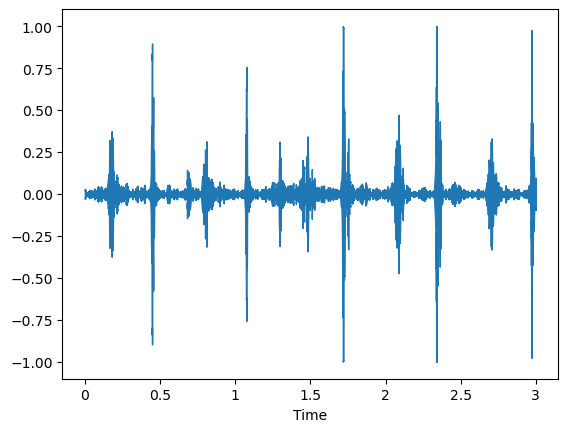

In [ ]:
sampledata, sampling_rate = librosa.load(INPUT_PATH + 'set_b/extrastole__127_1306764300147_C2.wav', duration=3)
librosa.display.waveshow(sampledata, sr=sampling_rate)

In [ ]:
# some important functions to generate features

def load_audio_timeseries(fileName, setName, offset=0, duration=None):
    if setName == 'a' :
        y, sr = librosa.load(INPUT_PATH + "set_a/" + fileName, sr=SAMPLE_RATE, offset=offset, duration=duration)
    elif setName == 'b' :
        y, sr = librosa.load(INPUT_PATH + "set_b/" + fileName, sr=SAMPLE_RATE, offset=offset, duration=duration)
    else:
        sys.exit('Please enter a valid Set')
    return(y)

In [ ]:
def combine_normal_extrastole(f):
    if f == "normal":
        return("normal/extrastole")
    elif f == "extrastole":
        return("normal/extrastole")
    else:
        return(f)

In [ ]:
import re
# Apply preprocessing to DataFrame column 'fname'
df['fname'] = df['fname'].apply(lambda f: f.split('/')[1])  # Extract filename from path
df['fname'] = [re.sub(r'Btraining_', '', str(x)) for x in df['fname']]  # Remove 'Btraining_' prefix

# Load audio time series and calculate audio duration
df['time_series'] = df.apply(lambda row: load_audio_timeseries(row['fname'], row['dataset']), axis=1)
df['audio_duration'] = round(df['time_series'].apply(len) / SAMPLE_RATE, 1)  # Calculate duration in seconds
df['label'] = df['label'].apply(combine_normal_extrastole)

In [ ]:
display(HTML('<h1 style="text-indent: 300px;">Subset of Audio Time Series Data </h1>'))
pd.concat([df.head() , df.tail()], ignore_index=True)

,dataset,fname,label,time_series,audio_duration
0,a,artifact__201012172012.wav,artifact,"[2.550026e-05, -0.00013188252, -0.00017918597,...",9.0
1,a,artifact__201105040918.wav,artifact,"[-1.1100718e-05, 1.2406408e-06, 1.9199924e-06,...",9.0
2,a,artifact__201105041959.wav,artifact,"[3.8810977e-05, -0.00016810001, -7.234428e-05,...",9.0
3,a,artifact__201105051017.wav,artifact,"[-0.0027586883, -0.006625162, -0.005011173, -0...",9.0
4,a,artifact__201105060108.wav,artifact,"[0.00014182099, 0.0014630123, 0.009762556, 0.0...",9.0
5,b,normal_noisynormal_284_1311168471850_A.wav,normal/extrastole,"[-0.0016496964, -0.0017047375, -0.0013140682, ...",12.1
6,b,normal_noisynormal_284_1311168471850_B.wav,normal/extrastole,"[0.018810578, 0.021118904, 0.021084417, 0.0188...",12.0
7,b,normal_noisynormal_285_1311169246969_C.wav,normal/extrastole,"[0.0095790215, 0.01158667, 0.0129514495, 0.013...",4.8
8,b,normal_noisynormal_296_1311682952647_C.wav,normal/extrastole,"[3.684312e-06, -0.0010473989, -0.002650246, -0...",13.1
9,b,normal_noisynormal_296_1311682952647_D.wav,normal/extrastole,"[0.027910102, 0.03220958, 0.033814296, 0.03315...",10.2


# Exploratory Data Analysis

## Summary Statistics and Visualization
* Checking the duration of the files among classes
* The class distribution of the dataset.

## Inspection of Audio and Data Quality
* Checking the overall data quality

## Feature Engineering
* What features can be used to train the model
* What length would be ideal to build the best classifier
* Is there enough information in the chosen length of the audio.


In [ ]:
# Summary Statistics and Visualization
cond_counts = df['label'].value_counts()
min_duration = df.groupby('label')['audio_duration'].min()
max_duration = df.groupby('label')['audio_duration'].max()
mean_duration = df.groupby('label')['audio_duration'].max()
total_duration = df.groupby('label')['audio_duration'].sum()

audio_duration_dict = {'min duration (sec)' : min_duration, 'max duration (sec)': max_duration, 'mean duration (sec)':mean_duration,
                       'total duration (sec)':total_duration, 'number of samples (#)': cond_counts}
audio_duration_summary = pd.DataFrame(audio_duration_dict)
display(HTML('<h1 style="text-indent: 300px;">Auditory Duration Summary</h1>'))
pd.DataFrame(audio_duration_dict)

,min duration (sec),max duration (sec),mean duration (sec),total duration (sec),number of samples (#)
label,,,,,
artifact,9.0,9.0,9.0,360.0,40
extrahls,0.9,9.0,9.0,130.5,19
murmur,0.9,24.2,24.2,1001.7,129
normal/extrastole,0.8,27.9,27.9,2486.5,397


The above table indicates that there is class imbalance (shown by number of samples).

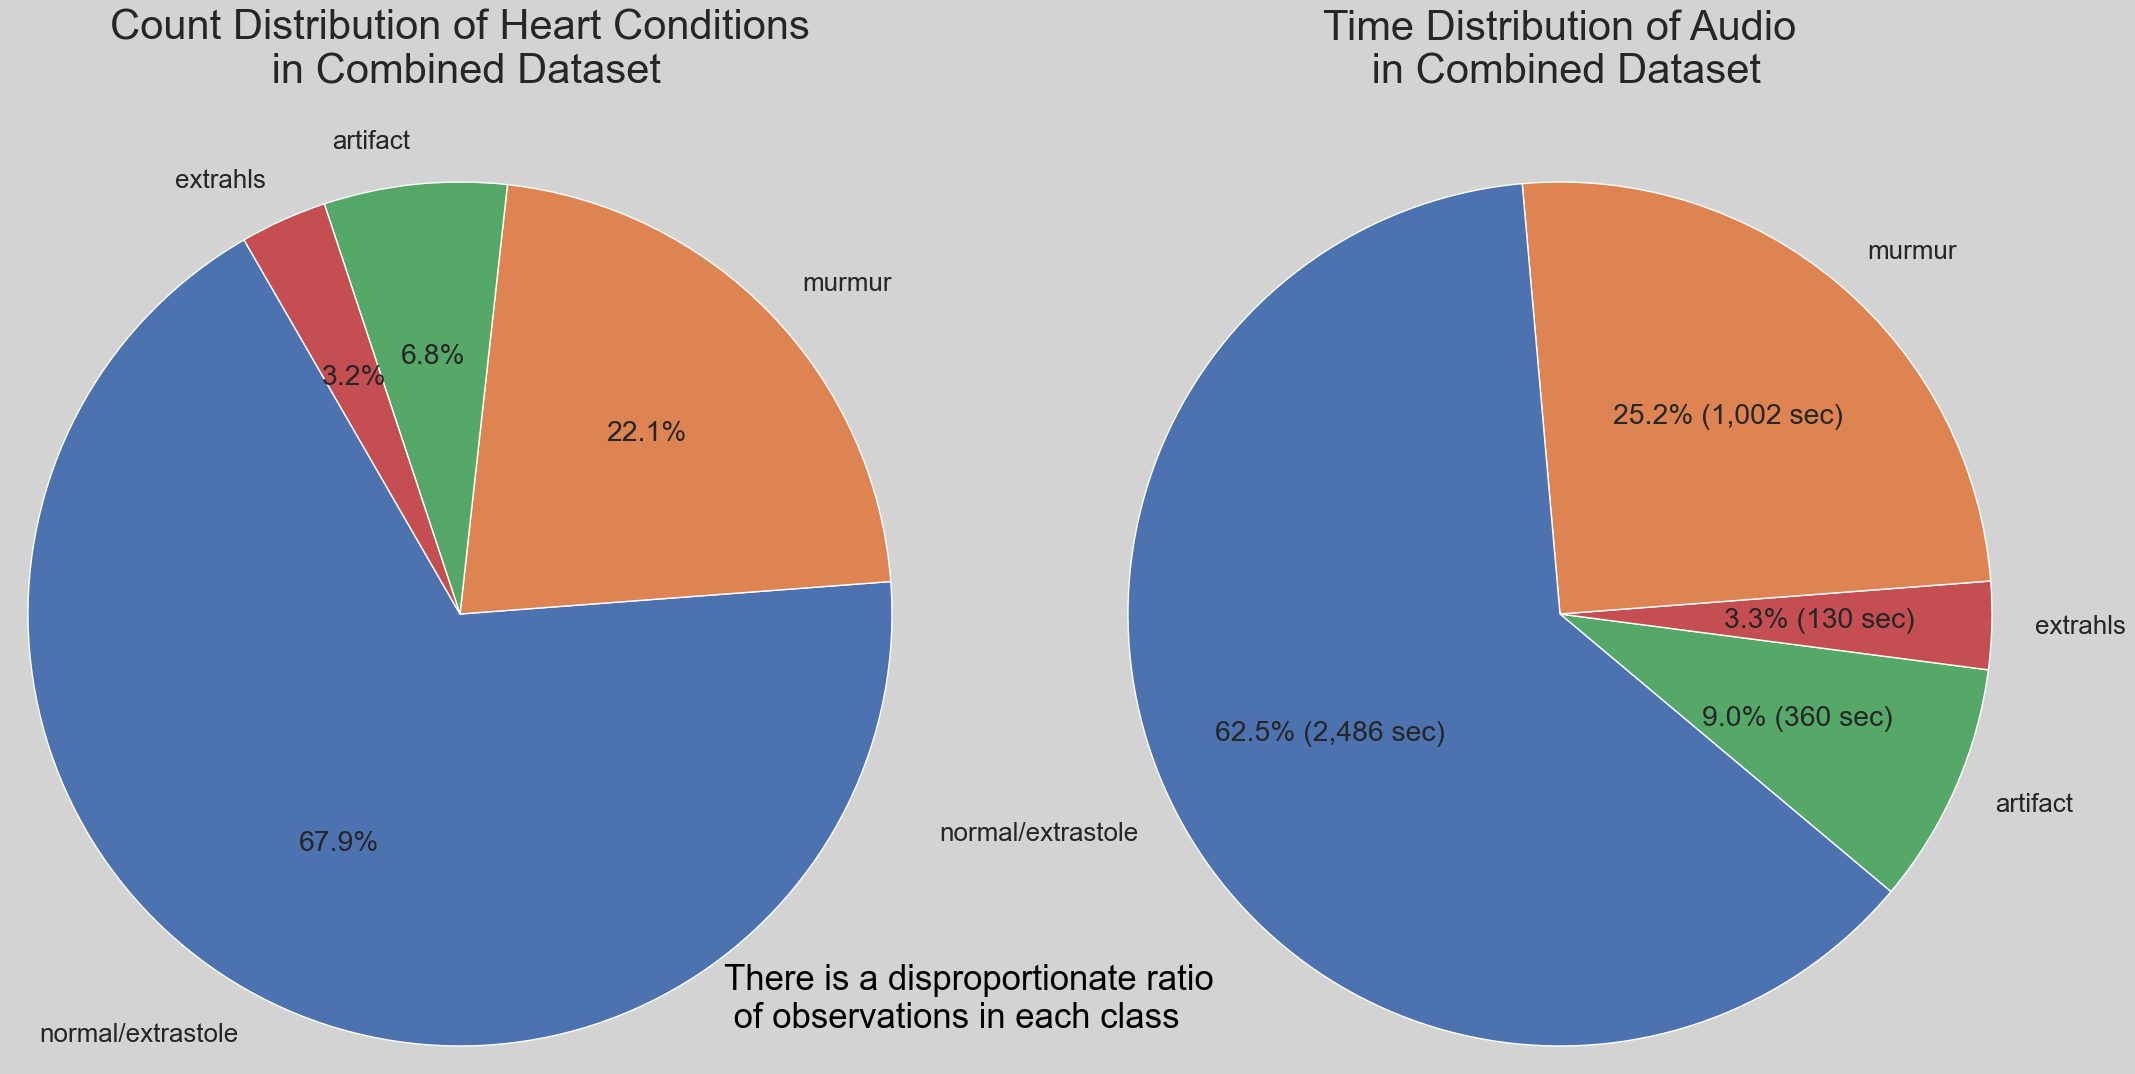

In [ ]:
# Visualizing

class_labels = list(cond_counts.index)
time_labels = list(total_duration.index)
label_counts = cond_counts.tolist()
duration_count = total_duration.tolist()

EDA.plot_two_distr(class_labels, label_counts, time_labels, duration_count)

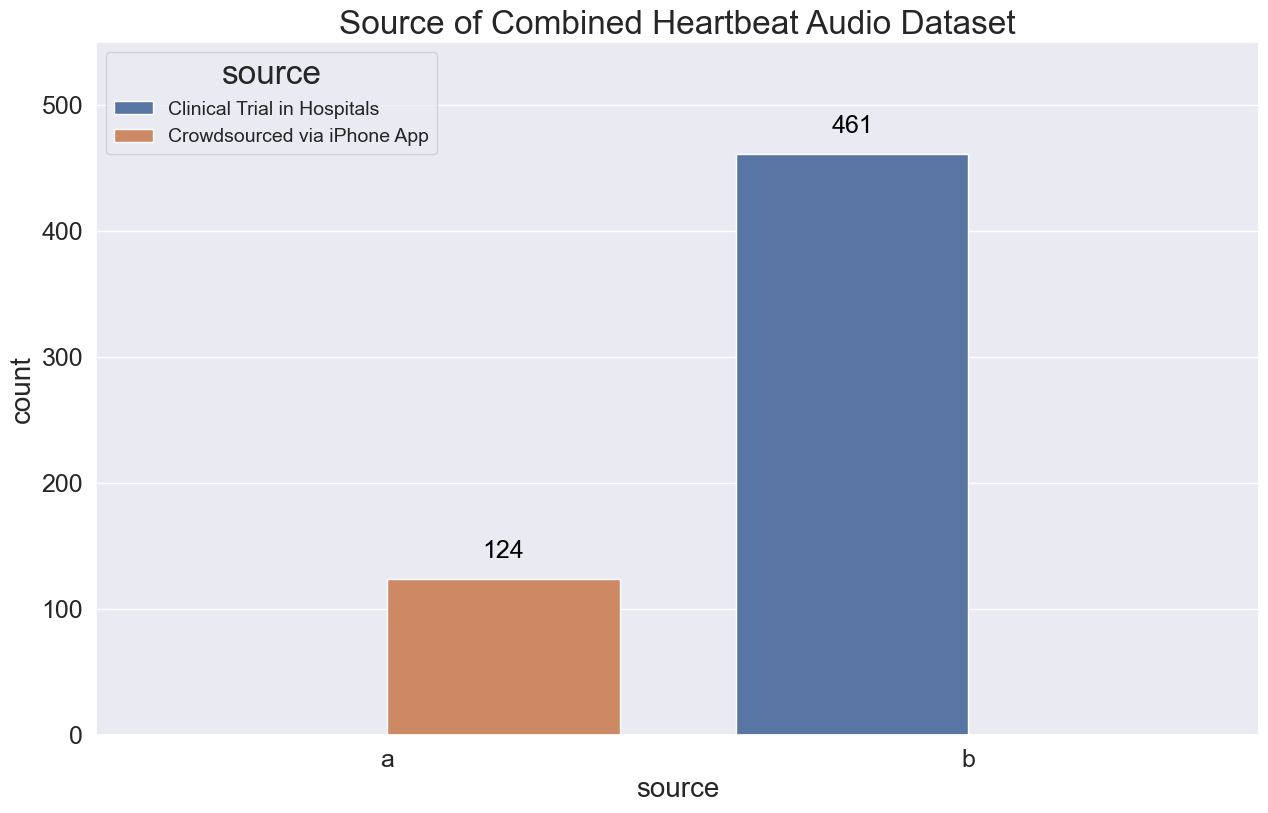

In [ ]:
# Checking the source distribution of the data
source_count = df['dataset'].value_counts()
l = source_count.to_frame()
l.reset_index(inplace=True)
l.columns = ['source', 'count']

EDA.plot_source_distr(l)

The above distribution indicates that majority of the audio files are from Set B. This could also mean that set B has better audio quality as opposed to set A which was recorded using iPhone.

# Visualizing using Oscillogram and Spectrogram
* An oscillogram is the measure of sound wave's amplitude versus time.


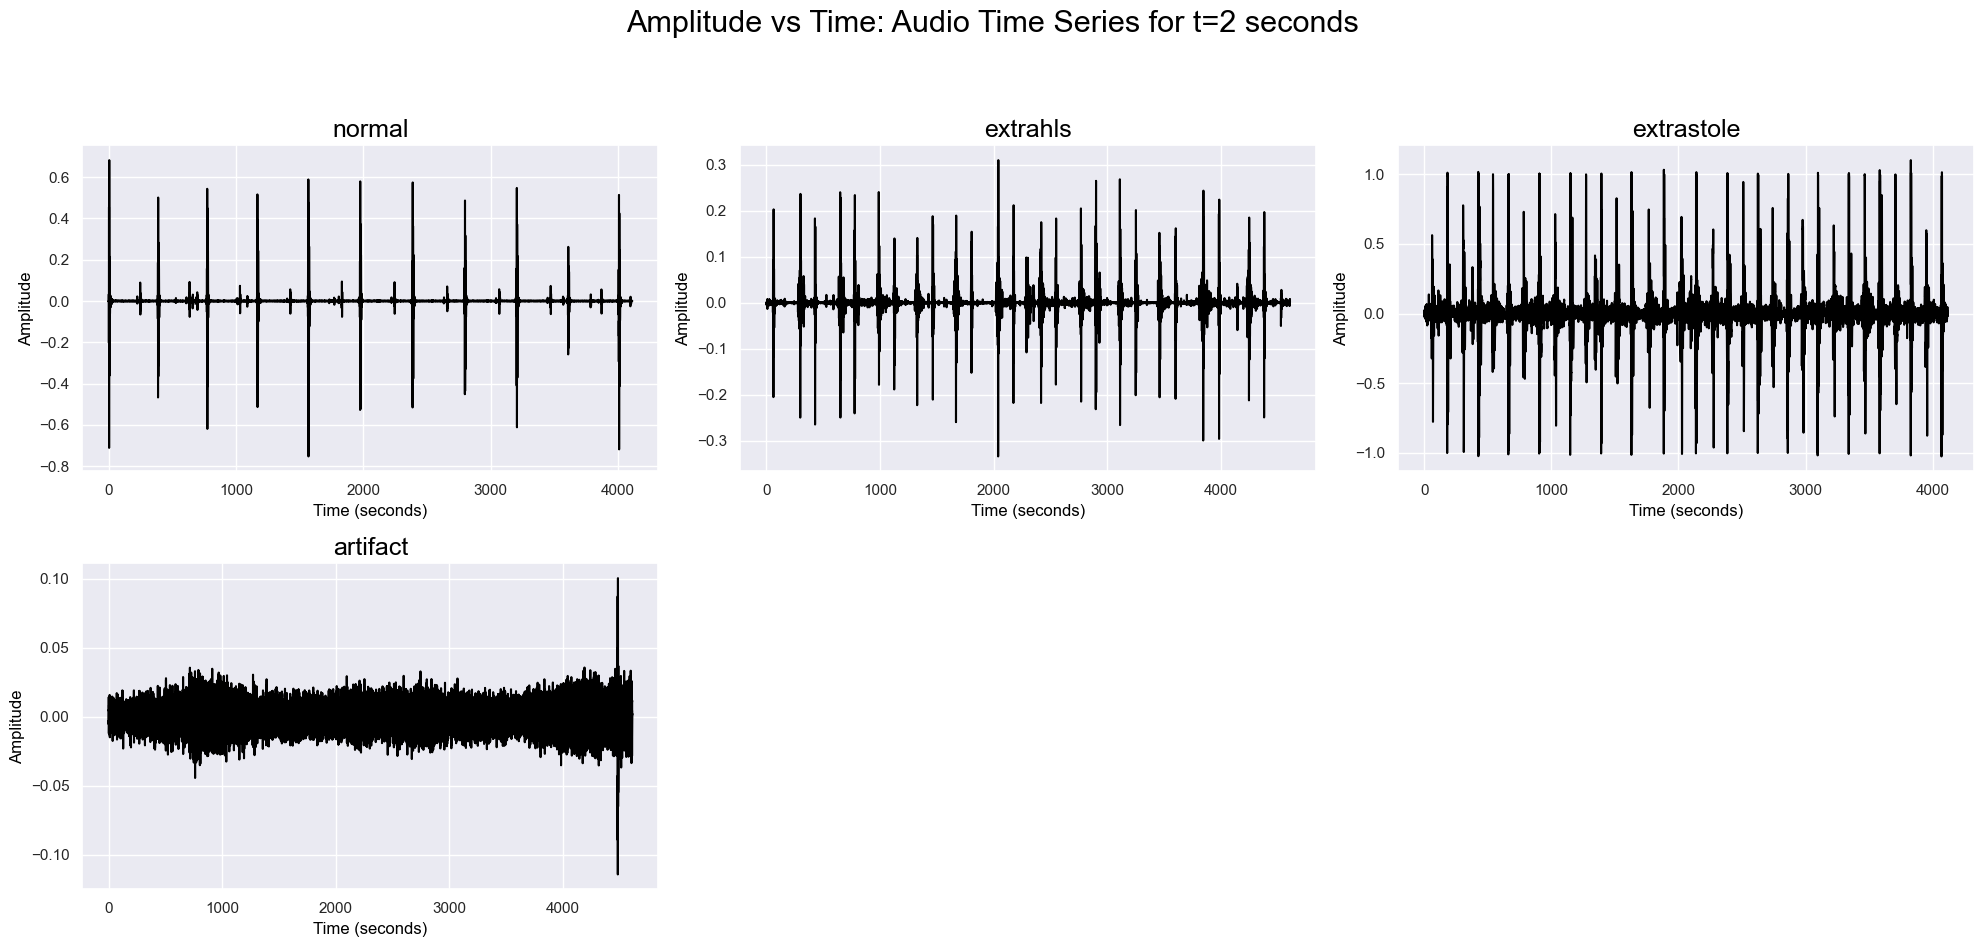

In [ ]:
def get_time_series(audio_fname,df):
    """" Helper function: returns the audio signal time series data """
    y = df.loc[df['fname'] == audio_fname]['time_series'].values[0]
    return(y)

samples = ['normal__201103170121.wav', 'extrahls__201101241423.wav',
            'extrastole__235_1308749032454_B.wav', 'artifact__201106171003.wav'] #  'murmur__201101180902.wav'

EDA.plot_signals(samples)

# Audio Analysis

* Amplitude is unrelated to the type of heartsound, amplitude is proportional to the volume of the audio.
* A wave with a large amplitude is considered as louder.

* Frequency is a good feature that should be extracted for the model.

# Feature Transformation: MFCCs
A commonly used transformation in digital signal processing is the MFCC.They are commonly used as features in speech recognition. MFCCs are a representation of the audio frequency. Below is a visualization of the Ceptral Coefficients vs Time.
The spectrogram shows how the cepstral coefficients hanges over time.

In [ ]:
""" Functions for Feature Extraction """

def new_extract_mfccs(y):
    try:
        # Calculate MFCC (Mel-frequency cepstral coefficients)
        mfccs = librosa.feature.mfcc(y=y, sr=SAMPLE_RATE, n_mfcc=13)
        # Take the mean across time (axis=1) to summarize MFCCs for the entire audio signal
        mfccs_mean = np.mean(mfccs, axis=1)
        return mfccs_mean
    except Exception as e:
        print(f"Error in new_extract_mfccs: {e}")
        return None

def new_extract_zcr(y):
    return(np.mean(librosa.feature.zero_crossing_rate(y)))

def new_extract_bandwidth(y):
    try:
        # Calculate spectral bandwidth
        bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=SAMPLE_RATE)
        return np.mean(bandwidth)
    except Exception as e:
        print(f"Error in new_extract_bandwidth: {e}")
        return None


def load_audio(file_path, start_sec, end_sec):
    y, sr = librosa.load(file_path, offset=start_sec, duration=(end_sec - start_sec))
    return y

# Set up Train and Test Data


Data will be split the combined audio data in a 70/30 training/testing split using Pandas.



In [ ]:
training_df = df.sample(frac = 0.7, random_state=42)
testing_df = df[~df['fname'].isin(training_df['fname'])]

In [ ]:
training_df

,dataset,fname,label,time_series,audio_duration
383,b,normal__218_1308246311449_C1.wav,normal/extrastole,"[-0.034508623, -0.0395951, -0.041319292, -0.04...",3.5
422,b,normal__286_1311170606028_A1.wav,normal/extrastole,"[-0.025363997, -0.030387446, -0.033514015, -0....",1.0
90,a,murmur__201108222255.wav,murmur,"[0.0041150614, 0.006603307, 0.006420425, 0.006...",7.9
472,b,normal_noisynormal_108_1305654420093_A.wav,normal/extrastole,"[-0.016032344, -0.01814178, -0.01844384, -0.01...",8.6
523,b,normal_noisynormal_138_1306762146980_D.wav,normal/extrastole,"[-0.009906163, -0.011849742, -0.012962579, -0....",5.7
...,...,...,...,...,...
232,b,murmur__288_1311164615284_D.wav,murmur,"[0.0102536045, 0.011700827, 0.012080992, 0.011...",11.4
115,a,normal__201106141148.wav,normal/extrastole,"[-0.0015043381, -0.0013419515, -0.00078000454,...",5.7
120,a,normal__201108011112.wav,normal/extrastole,"[0.0071145976, 0.011338571, 0.0107074315, 0.01...",7.9
457,b,murmur_noisymurmur_243_1309197760898_B.wav,murmur,"[-0.11213275, -0.13057522, -0.13841549, -0.136...",12.9


# Sanity Check: Train/Test Split Verification

In [ ]:
print("=== Training Dataset ===")
print(training_df.groupby('dataset').label.value_counts())
print("\nnumber of rows = {0}\n".format(len(training_df)))
print("=== Test Dataset ===")
print(testing_df.groupby('dataset').label.value_counts())
print("\nnumber of rows = {0}".format(len(testing_df)))

=== Training Dataset ===
dataset  label            
a        artifact              27
         murmur                25
         normal/extrastole     22
         extrahls              11
b        normal/extrastole    258
         murmur                67
Name: count, dtype: int64

number of rows = 410

=== Test Dataset ===
dataset  label            
a        artifact              13
         murmur                 9
         normal/extrastole      9
         extrahls               8
b        normal/extrastole    108
         murmur                28
Name: count, dtype: int64

number of rows = 175


The results above show that the data was split properly.

# Data Augmentation and Feature Extraction
More data will be generated by splitting two seconds of audio along the length of existing audio files. This will effectively increase the sample size.

In [ ]:
import sys

# Constants and global variables
INPUT_PATH = 'input/combined/'  # Base path where audio files are stored
SAMPLE_RATE = 22050  # Sample rate for audio processing
AUDIO_DURATION = 2  # Duration (in seconds) for audio chunks

def load_audio_timeseries(fileName, offset=0, duration=None):
    try:
        # Load audio file from the combined folder
        filePath = INPUT_PATH + fileName
        y, sr = librosa.load(filePath, sr=SAMPLE_RATE, offset=offset, duration=duration)
        return y  # Return audio time series
    except FileNotFoundError as e:
        print(f"Error: File not found - {filePath}")
        return None

# Function to repeat a numpy 1D array to a given length
def repeat_to_length(arr, length):
    result = np.empty((length, ), dtype='float32')
    l = len(arr)
    pos = 0
    while pos + l <= length:
        result[pos:pos+l] = arr
        pos += l
    if pos < length:
        result[pos:length] = arr[:length-pos]
    return result

def split_audio(fname):
    try:
        duration = training_df.loc[training_df['fname'] == fname, 'audio_duration'].values[0]
        my_list = []

        y = load_audio_timeseries(fname, offset=0, duration=AUDIO_DURATION)  # Load initial 2-second chunk
        if duration < 2:
            y = repeat_to_length(y, SAMPLE_RATE * 2)

        i = 0
        count = 1
        while True:
            if i > 0:
                y = load_audio_timeseries(fname, offset=i, duration=AUDIO_DURATION)

            data = {
                'fname': f"{fname}_{count}",
                'label': training_df.loc[training_df['fname'] == fname, 'label'].values[0],
                'time_series': y,
                'mfccs': new_extract_mfccs(y),
                'zcr': new_extract_zcr(y),
                'bandwidth': new_extract_bandwidth(y),
                'audio_duration': round(len(y) / SAMPLE_RATE, 1)
            }

            my_list.append(pd.Series(data))

            i += 2
            count += 1
            if i + 2 > duration:
                break

        return my_list
    except Exception as e:
        print(f"Error in split_audio for fname {fname}: {e}")
        return []

In [ ]:
# Generate more training data using split_audio
split_results = training_df['fname'].apply(split_audio)

# Flatten the list of lists into a single list of Series
split_results_flat = [item for sublist in split_results for item in sublist]

# Concatenate the Series into a DataFrame
new_training_df = pd.DataFrame(split_results_flat)


# Sanity Check: Splitting the audio
The duration of each audio file should be 2 seconds each.

In [ ]:
""" List the unique values in the duration column """
new_training_df['audio_duration'].unique()

array([2.])

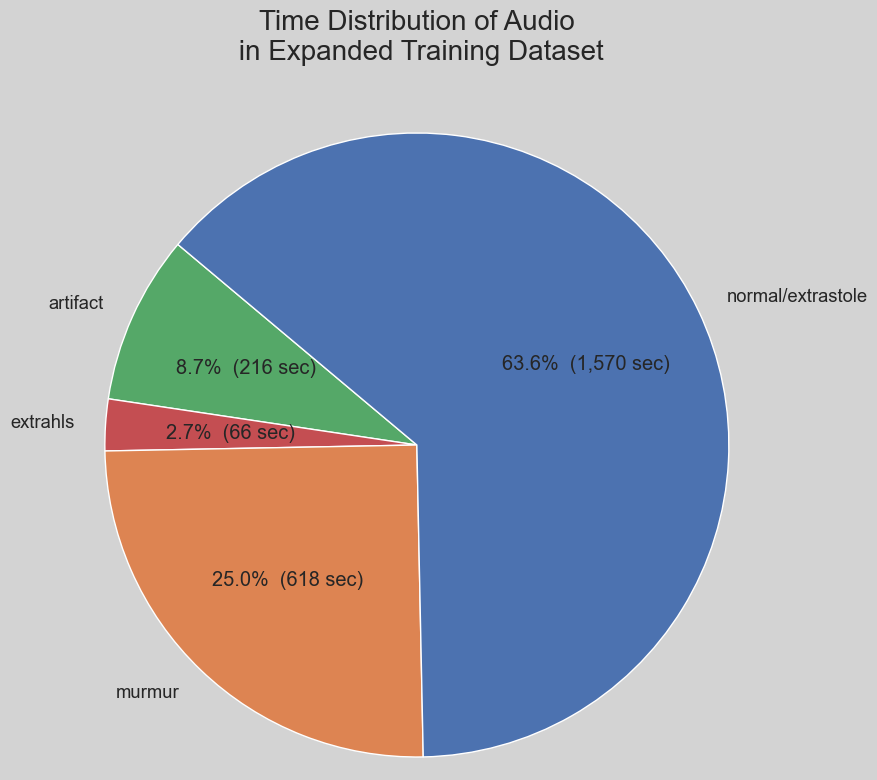

In [ ]:
total_duration = new_training_df.groupby('label')['audio_duration'].sum()
time_labels = list(total_duration.index)
duration_count = total_duration.tolist()
EDA.plot_time_dist(time_labels, duration_count)

In [ ]:
#inspecting dataframe

display(HTML('<h1 style="text-indent: 300px;">Subset of Training Dataset with Features</h1>'))
pd.concat([new_training_df.head(), new_training_df.tail()], ignore_index=True)

,fname,label,time_series,mfccs,zcr,bandwidth,audio_duration
0,normal__218_1308246311449_C1.wav_1,normal/extrastole,"[-0.034508623, -0.0395951, -0.041319292, -0.04...","[-360.4191, 163.33334, 50.138866, -5.1341333, ...",0.013206,437.324630,2.0
1,normal__286_1311170606028_A1.wav_1,normal/extrastole,"[-0.025363997, -0.030387446, -0.033514015, -0....","[-334.65997, 156.88557, 68.80706, 14.1792965, ...",0.010400,387.849109,2.0
2,murmur__201108222255.wav_1,murmur,"[0.0041150614, 0.006603307, 0.006420425, 0.006...","[-467.56653, 69.34039, 62.29271, 53.270004, 43...",0.004338,429.633395,2.0
3,murmur__201108222255.wav_2,murmur,"[0.013387699, 0.019643754, 0.017532216, 0.0191...","[-465.32556, 71.36865, 63.46401, 53.82605, 44....",0.004698,451.065169,2.0
4,murmur__201108222255.wav_3,murmur,"[0.011252245, 0.016415736, 0.014525698, 0.0157...","[-467.37012, 70.33434, 63.1678, 53.76814, 43.9...",0.004838,438.310953,2.0
5,murmur_noisymurmur_243_1309197760898_B.wav_3,murmur,"[-0.027472692, -0.024329018, -0.015514176, -0....","[-367.08444, 193.7632, 48.949802, -25.701237, ...",0.019761,434.159660,2.0
6,murmur_noisymurmur_243_1309197760898_B.wav_4,murmur,"[-0.007334305, -0.008627716, -0.009422764, -0....","[-372.69516, 194.24872, 50.752476, -26.749992,...",0.023162,424.427008,2.0
7,murmur_noisymurmur_243_1309197760898_B.wav_5,murmur,"[-0.007107027, -0.008692812, -0.00985557, -0.0...","[-365.03384, 200.66206, 47.963356, -32.553566,...",0.022528,428.362341,2.0
8,murmur_noisymurmur_243_1309197760898_B.wav_6,murmur,"[0.019244496, 0.023091922, 0.02549416, 0.02660...","[-370.26575, 200.74567, 51.075424, -28.620378,...",0.024813,439.686631,2.0
9,normal__214_1308245489717_A.wav_1,normal/extrastole,"[0.007228693, 0.008006962, 0.007917648, 0.0071...","[-407.21844, 219.84323, 54.41234, -27.72574, -...",0.011713,427.993264,2.0


# Oversampling the Minority class

In [ ]:
""" Separate majority and minority classes """
train_df_majority = new_training_df[new_training_df.label=="normal/extrastole"]
train_df_minority1 = new_training_df[new_training_df.label=="murmur"]
train_df_minority2 = new_training_df[new_training_df.label=="extrahls"]
train_df_minority3 = new_training_df[new_training_df.label=="artifact"]

# Upsample the Minority Classes

In [ ]:
majority_num = train_df_majority.shape[0]

""" Upsample the minority classes """
df_minority1_upsampled = resample(train_df_minority1,
                                 replace=True,     # sample with replacement
                                 n_samples=majority_num,    # to match majority class
                                 random_state=42) # reproducible results

df_minority2_upsampled = resample(train_df_minority2,
                                 replace=True,
                                 n_samples=majority_num,
                                 random_state=42)

df_minority3_upsampled = resample(train_df_minority3,
                                 replace=True,
                                 n_samples=majority_num,
                                 random_state=42)

In [ ]:
""" Combine majority class with the upsampled minority classes """
df_upsampled = pd.concat([train_df_majority,
                          df_minority1_upsampled,
                          df_minority2_upsampled,
                          df_minority3_upsampled],
                         ignore_index=False)

# Sanity Check: Upsampling the Minority Classes

In [ ]:
""" Display new class Distribution """
print("New Class Distribution")
df_upsampled.label.value_counts()

New Class Distribution


label
normal/extrastole    785
murmur               785
extrahls             785
artifact             785
Name: count, dtype: int64

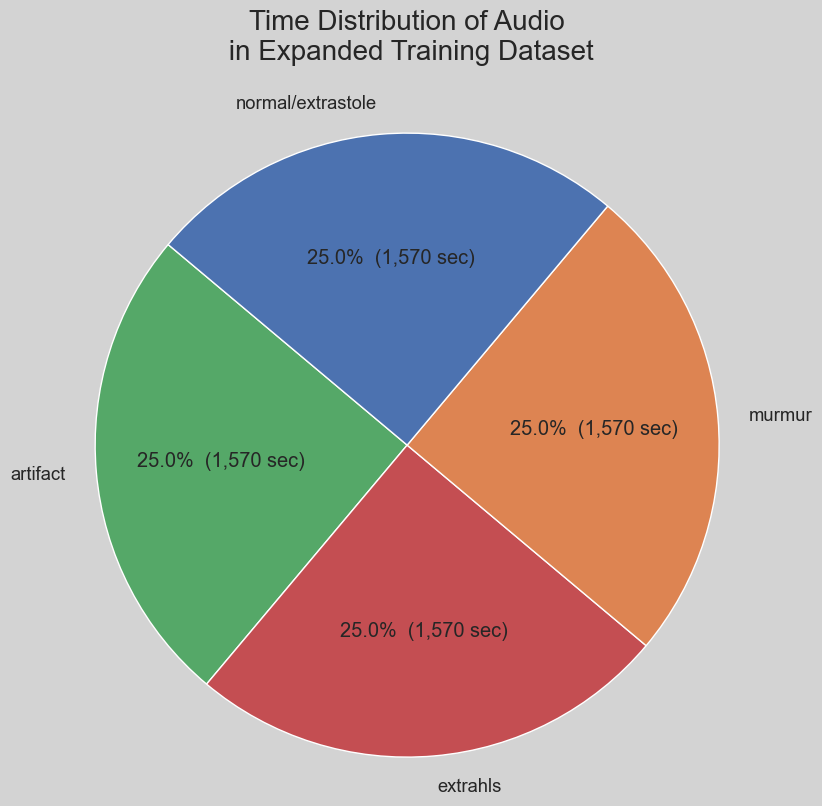

In [ ]:
total_duration = df_upsampled.groupby('label')['audio_duration'].sum()
time_labels = list(total_duration.index)
duration_count = total_duration.tolist()
EDA.plot_time_dist(time_labels, duration_count)

The results above indicate that the Minority Classes were properly Up-Sampled

In [ ]:
testing_df['time_series'] = df['fname'].apply(load_audio_timeseries)   # audio signals
testing_df['audio_duration'] = round(testing_df['time_series'].apply(len) / SAMPLE_RATE, 1)

C:\Users\HP\AppData\Local\Temp\ipykernel_1248\1203220668.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_df['time_series'] = df['fname'].apply(load_audio_timeseries)   # audio signals
C:\Users\HP\AppData\Local\Temp\ipykernel_1248\1203220668.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_df['audio_duration'] = round(testing_df['time_series'].apply(len) / SAMPLE_RATE, 1)


In [ ]:
testing_df['mfccs'] = testing_df['time_series'].apply(new_extract_mfccs)
testing_df['zcr'] = testing_df['time_series'].apply(new_extract_zcr)
testing_df['bandwidth'] = testing_df['time_series'].apply(new_extract_bandwidth)

C:\Users\HP\AppData\Local\Temp\ipykernel_1248\3671348743.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_df['mfccs'] = testing_df['time_series'].apply(new_extract_mfccs)
C:\Users\HP\AppData\Local\Temp\ipykernel_1248\3671348743.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testing_df['zcr'] = testing_df['time_series'].apply(new_extract_zcr)
C:\Users\HP\AppData\Local\Temp\ipykernel_1248\3671348743.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFram

In [ ]:
mfccs = np.vstack(df_upsampled['mfccs'])
zcr = np.vstack(df_upsampled['zcr'])
bandwidth = np.vstack(df_upsampled['bandwidth'])

test_mfccs = np.vstack(testing_df['mfccs'])
test_zcr = np.vstack(testing_df['zcr'])
test_bandwidth = np.vstack(testing_df['bandwidth'])

""" Normalize the training data """
mfccs = mfccs / np.std(mfccs, axis=0)
zcr = zcr / np.std(zcr, axis=0)
bandwidth = bandwidth / np.std(bandwidth, axis=0)

""" Normalize the testing data """
test_mfccs = test_mfccs / np.std(test_mfccs, axis=0)
test_zcr = test_zcr / np.std(test_zcr, axis=0)
test_bandwidth = test_bandwidth / np.std(test_bandwidth, axis=0)

In [ ]:
# One-Hot Encoding
trainLabels_encoded = pd.get_dummies(df_upsampled['label'])


In [ ]:
# Buidling Deep Neural Network
""" Define Callback Function """
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.8**x)

checkpoint = ModelCheckpoint("weights.keras", monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint, annealer]

In [ ]:
import tensorflow.keras.backend as K
warnings.filterwarnings('ignore')

# input tensors: mfccs, zero crossing rate, spectral bandwidth
x1 = Input(shape =(13,), dtype = 'float32', name = 'mfccs')
x2 = Input(shape =(1,), dtype = 'float32', name = 'zcr')
x3 = Input(shape =(1,), dtype = 'float32', name = 'bandwidth')

input_layer = concatenate([x1,x2,x3])

hl1 = Dense(units=64, activation='relu')(input_layer)
hl2 = Dense(units=32, activation='relu')(hl1)
hl3 = Dense(units=16, activation='relu')(hl2)
x = Dropout(rate=0.2)(hl3)
predictions = Dense(4, activation='softmax')(x)

model = Model(inputs=[x1,x2,x3],
              outputs=predictions)
# Define the optimizer and compile the model
optimizer = Adam(learning_rate=0.0001, decay=1e-6)
model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ mfccs (InputLayer)  │ (None, 13)        │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zcr (InputLayer)    │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bandwidth           │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 15)        │          0 │ mfccs[0][0],      │
│ (Concatenate)       │                   │            │ zcr[0][0],        │
│                     │                   │            │ bandwidth[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 64)        │      1,024 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 32)        │      2,080 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 16)        │        528 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16)        │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 4)         │         68 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,700 (14.45 KB)

 Trainable params: 3,700 (14.45 KB)

 Non-trainable params: 0 (0.00 B)

# Fitting the Model
To avoid overfitting the training data, we only train the model for 10 epochs.



In [ ]:
history = model.fit(x = [mfccs, zcr, bandwidth],
                    y = trainLabels_encoded,
                    validation_split=0.1,
                    epochs = 10,
                    batch_size = 8,
                   callbacks=callbacks_list,
                   verbose=1)

Epoch 1/10
349/354 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5656 - loss: 0.9564
Epoch 1: val_loss improved from inf to 0.37637, saving model to weights.keras
354/354 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5672 - loss: 0.9532 - val_accuracy: 0.9204 - val_loss: 0.3764 - learning_rate: 0.0010
Epoch 2/10
349/354 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7633 - loss: 0.5129
Epoch 2: val_loss improved from 0.37637 to 0.09651, saving model to weights.keras
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7635 - loss: 0.5126 - val_accuracy: 0.9650 - val_loss: 0.0965 - learning_rate: 8.0000e-04
Epoch 3/10
339/354 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7926 - loss: 0.4379
Epoch 3: val_loss improved from 0.09651 to 0.04740, saving model to weights.keras
354/354 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.7926 - loss: 0.4374 - val_accuracy: 0.9904 - val_loss: 0.0474 - learning_rate: 6.4000e-04
Epoch 4/10
341/354 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.806

We trained on 2822 samples, and validated on 314 samples. The model performed really well. On the first pass of the data, the model achieved an accuracy of 75% on the training set and an accuracy of 95% on the validation set. Eventually the model achieves an accuracy of 85% on the training set and an accuracy of 99% on the validation set.



In [ ]:
import os
from tensorflow.keras.models import load_model

# Assuming 'model' is already trained

# Define the directory path where you want to save the model
save_dir = 'trained_model'

# Create the directory if it does not exist
# if not os.path.exists(save_dir):
#     os.makedirs(save_dir)

# Define the file path within the directory to save the model
model_filename = 'trained-model.keras'
model_path = os.path.join(save_dir, model_filename)

# Save the trained model to the specified file path
model.save(model_path)

print(f"Model saved to: {model_path}")


Model saved to: trained_model\trained-model.keras


Code to load the trained model later (if needed)

In [ ]:
# # Define the path to the saved model within the 'trained_model' directory
# saved_model_path = os.path.join(save_dir, model_filename)

# # Load the saved model
# loaded_model = load_model(saved_model_path)

# # Now you can use 'loaded_model' for prediction or further training

# Making Predictions

In [ ]:
testLabels = testing_df['label'].tolist()

y_prob = model.predict([test_mfccs, test_zcr, test_bandwidth])
y_classes = y_prob.argmax(axis=-1)

labelsDict = {'artifact': 0, 'extrahls':1, 'murmur':2, 'normal/extrastole':3}
y_actu = [labelsDict[k] for k in testLabels]
y_pred = y_classes.tolist()

# binarize/hotencode y_actu
y_binary = label_binarize(np.array(y_actu), classes=[0,1,2,3])
n_classes = y_binary.shape[1]    # 4 classes

6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


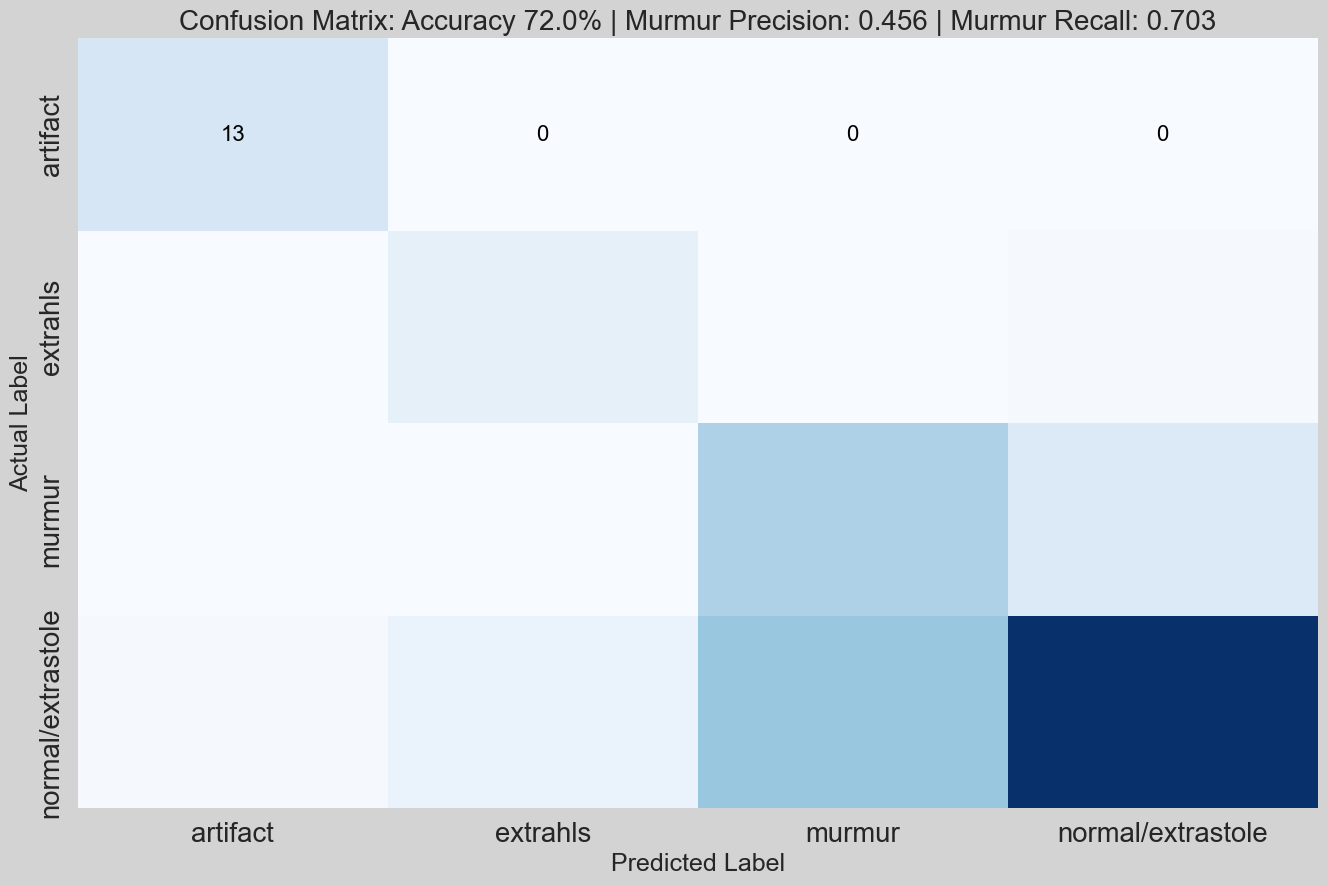

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Compute confusion matrix
cm = confusion_matrix(y_actu, y_pred)

# Create DataFrame from confusion matrix
categories = ["artifact", "extrahls", "murmur", "normal/extrastole"]
df_cm = pd.DataFrame(cm, index=categories, columns=categories)

# Compute Precision, Recall, F-score
precision = precision_score(y_actu, y_pred, average=None)
recall = recall_score(y_actu, y_pred, average=None)
fscore = f1_score(y_actu, y_pred, average=None)

# Round precision and recall values for 'murmur' class
murmur_precision = round(precision[2], 3)
murmur_recall = round(recall[2], 3)

# Create a figure and set its size
plt.figure(figsize=(16, 10), facecolor='lightgrey')

# Plot confusion matrix heatmap with annotations
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='.0f', annot_kws={"size": 16, "color": "black"}, square=False, cbar=False)

# Set labels and title
plt.ylabel('Actual Label', size=18)
plt.xlabel('Predicted Label', size=18)
cm_title = f"Confusion Matrix: Accuracy {round(accuracy_score(y_actu, y_pred) * 100, 1)}% | " \
           f"Murmur Precision: {murmur_precision} | Murmur Recall: {murmur_recall}"
plt.title(cm_title, size=20)

plt.show()

# Precision, Recall, and F1 Score
* Precision is the proportion of correct positive classifications (true positives) from cases that are predicted as positive.

* Recall (also called sensitivity) is the proportion of correct positive classifications (true positives) from cases that are actually positive.

* F1 Score is the harmonic mean of Precision and Recall.

In [ ]:
# Create pandas Series from NumPy arrays
precision_series = pd.Series(precision, name='Precision')
recall_series = pd.Series(recall, name='Recall')
fscore_series = pd.Series(fscore, name='F-score')

# Concatenate Series into a DataFrame along columns (axis=1)
metrics_df = pd.concat([precision_series, recall_series, fscore_series], axis=1)

print(metrics_df)

   Precision    Recall   F-score
0   0.928571  1.000000  0.962963
1   0.583333  0.875000  0.700000
2   0.456140  0.702703  0.553191
3   0.869565  0.683761  0.765550


The goal of the classifer was to optimize for the murmur category because that category had the highest implication cost.



# ROC and AUC Curve

In [ ]:
"""Compute ROC curve and ROC area for each class"""
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_binary[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

"""Compute micro-average ROC curve and ROC area"""
fpr["micro"], tpr["micro"], _ = roc_curve(y_binary.ravel(), y_prob.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [ ]:
"""Compute macro-average ROC curve and ROC area"""

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

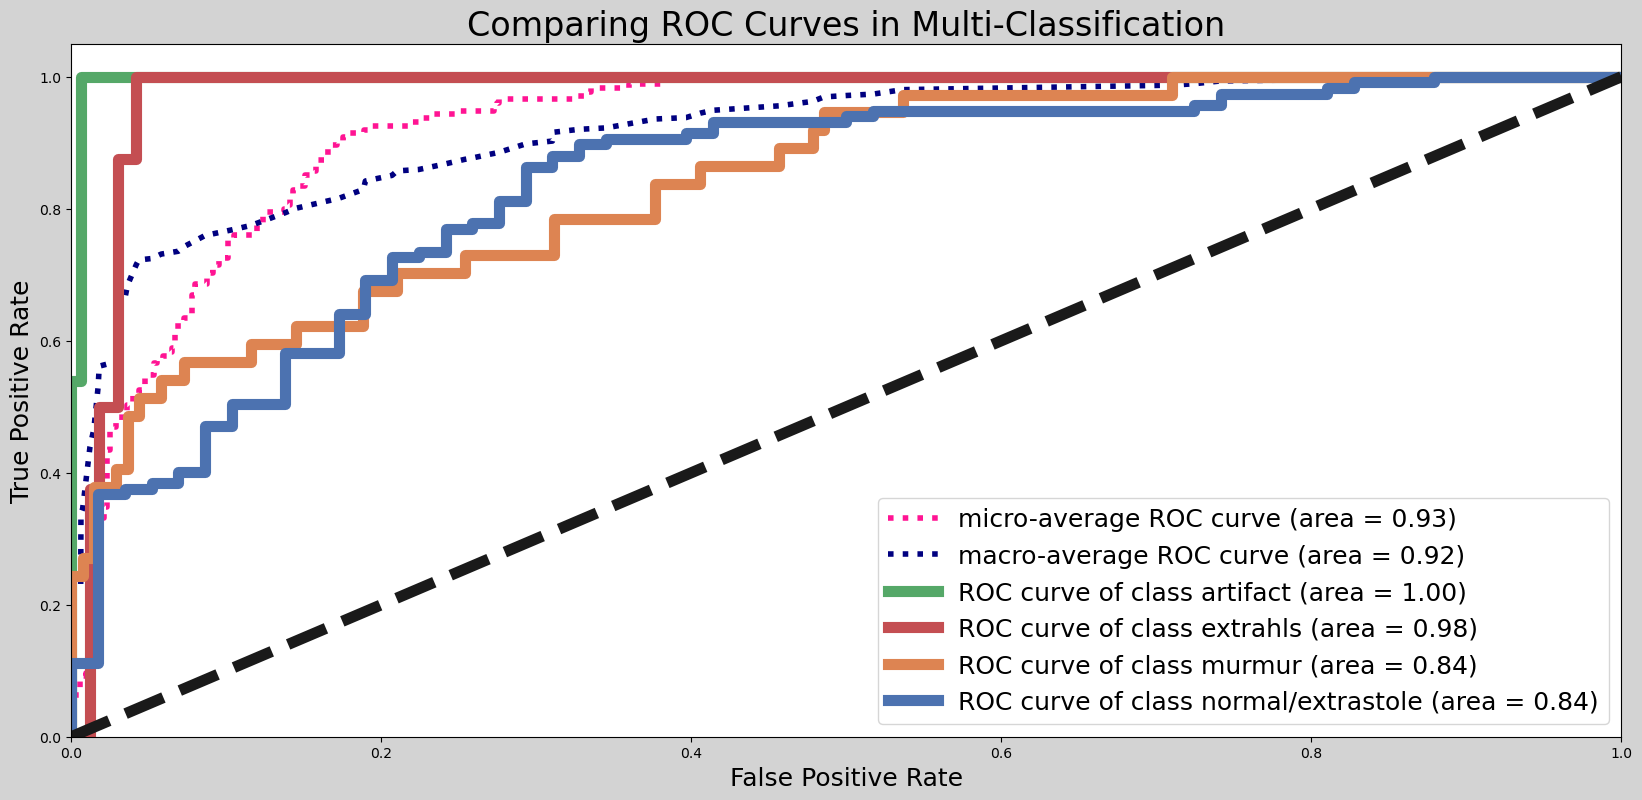

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)
plt.figure(figsize=(20,9), facecolor='lightgrey')
lw = 8            # line width
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = ['#55A868', '#C44E52', '#DD8452', '#4C72B0']
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(categories[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Comparing ROC Curves in Multi-Classification', fontsize=24)
plt.legend(loc="lower right", fontsize=18)
plt.show()

As shown in the figure above, the ROC curve for class murmur is well above the 45-degree diagonal. The AUC for the murmur class is 0.77. This indicates that the model is fairly accurate at detecting heart murmurs.